# The Finite Element Method

## An Illustrative Problem

Consider the following problem

$$
\frac{d^2 u}{dx^2} = f(x) = x, \quad x \in \left[0, 1\right], \quad u(0) = u(1) = 0
$$

The solution to this boundary value problem is

$$
\hat u(x) = \frac{1}{6} x (1 - x^2)
$$

But let us try to approximate this using the finite element method.  To do this, consider a function $\phi(x) \in C^1\left[0, 1\right]$, which has 

$$
\phi(0) = \phi(1) = 0
$$

Such a $\phi$ is called a trial function.  Then consider the inner product:

$$
\left\langle \phi, \frac{d^2 u}{dx^2}\right\rangle := \int_0^1 \phi \frac{d^2 u}{dx^2} \, dx
$$

Integrating by parts gives

$$
\left\langle \phi, \frac{d^2 u}{dx^2}\right\rangle = \left.\phi \frac{du}{dx}\right|_0^1 - 
\int_0^1 \frac{d\phi}{dx} \frac{du}{dx} \, dx
$$

The boundary condition on $\phi$ gives

$$
\left\langle \phi, \frac{d^2 u}{dx^2}\right\rangle = - 
\int_0^1 \frac{d\phi}{dx} \frac{du}{dx} \, dx = - \left\langle \frac{d\phi}{dx}, \frac{du}{dx}\right\rangle
$$

Therefore 

$$
\left\langle \phi, \frac{d^2 u}{dx^2}\right\rangle = - \left\langle \frac{d\phi}{dx}, \frac{du}{dx}\right\rangle
= \langle \phi, f \rangle
$$

This is called the weak form of the problem.  Now how do we use this.  Suppose we have $\{\phi_j\}_{j\in\mathbb{N_0}}$, such that they form a complete space on $C^1\left[0, 1\right]$.  Then we may write

$$
u(x) = \sum_{j=0}^\infty c_j \phi_j(x)
$$

Applying this to the weak form (with $\phi = \phi_k$) gives

$$
-\sum_{j=0}^\infty c_j \left\langle \frac{d\phi_k}{dx}, \frac{d\phi_j}{dx} \right\rangle = 
\langle \phi_k, f\rangle
$$

For practicle purposes, we can only compute a finite sum.  Therefore let us use $j$ from 1 to $N < \infty$.
Furthermore, we can define a matrix $A$ and vectors $b$ and $c$ such that 

$$
A_{kj} = -\left\langle \frac{d\phi_k}{dx}, \frac{d\phi_j}{dx}\right\rangle, \quad 
b_k = \langle \phi_k, f\rangle \implies Ac = b
$$

Therefore we can solve this matrix equation for the vector $c$, get the coefficients of $\phi_j$, and 
approximate $u$.

## An Example

For a simple example we will use $\phi_j$ as the hat functions.  This means we discretize $\left[0, 1\right]$ using nodes $0 = x_0 < x_1 < ... < x_N < x_{N+1} = 1$.  We define the hat functions $\hat \phi_j$ as follows:

$$
\hat \phi_j(x) = \begin{cases}
\frac{1}{x_j - x_{j-1}} (x - x_{j-1}) & x \in \left[x_{j-1}, x_j\right] \\
\frac{-1}{x_{j+1} - x_j} (x - x_{j+1}) & x \in \left(x_j, x_{j+1}\right) \\
0 & \mathrm{otherwise}
\end{cases}
$$

Each of these is $C^1\left[0, 1\right]$, except at three points.  Since this is a set of measure zero,
we can safely ignore it.  In order to satisfy the boundary conditions, we exclude $\phi_0$ and $\phi_{N+1}$.

Next to examine is the problem of determining $A_{ij}$.  This will be a tridiagonal matrix, as the overlap 
between $\phi_j$ and $\phi_{j+2}$ is zero.  The values on the diagonals however, are computed via an integral.
To evaluate this, we need an integration method which is accurate for quadratic functions.  This can be done using the quadrature:

$$
\int_a^b f(x) \, dx \approx Q\left[f\right] := \frac{(b - a)}{6} \left[f(a) + 4 f\left(\frac{a + b}{2}\right) + 
f(b) \right]
$$

Using this we can build the finite element method

In [257]:
# imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quadrature
import scipy.linalg as la

In [240]:
# exact solution and right hand side
f = lambda x: x
uhat = lambda x: 1.0/6 * x * (1 - np.power(x, 2))

# quadrature
def quaddoe2(f, a, b):
    val = (b - a) / 6 * (f(a) + 4*f((a + b) / 2) + f(b))
    return val

a = lambda x: x**2
print(quad(a, 0, 1))

(0.33333333333333337, 3.700743415417189e-15)


In [288]:
# discretization, equally spaced nodes
xspan = [0, 1]
N = 2
x_nodes = np.linspace(xspan[0], xspan[1], N+2)

print(x_nodes)

# hat functions
def hat_fun(x, nodes, index):
    # build the j'th hat function, j = index, vectorized
    phi = np.zeros(np.shape(x))
    if index > 0:
        left_indices = (x > nodes[index-1]) * (x <= nodes[index])
        phi[left_indices] = (x[left_indices] - nodes[index-1]) / (nodes[index] - nodes[index-1])
    if index < len(nodes) - 1:
        right_indices = (x > nodes[index]) * (x < nodes[index+1])
        phi[right_indices] = -(x[right_indices] - nodes[index+1]) / (nodes[index + 1] - nodes[index])
    else:
        phi[-1] = 0
    
    return phi

# hat function derivatives
def hat_fun_der(x, nodes, index):
    # build the j'th hat function, j = index, vectorized
    phi = np.zeros(np.shape(x))
    if index > 0:
        left_indices = (x >= nodes[index-1]) * (x <= nodes[index])
        phi[left_indices] = 1.0 / (nodes[index] - nodes[index-1])
    if index < len(nodes) - 1:
        right_indices = (x > nodes[index]) * (x <= nodes[index+1])
        phi[right_indices] = -1.0 / (nodes[index + 1] - nodes[index])
    else:
        phi[-1] = 0
    return phi

def hat_fun_nonvec(x, nodes, index):
    if x > nodes[index-1] and x <= nodes[index]:
        return (x - nodes[index-1]) / (nodes[index] - nodes[index-1])
    elif x > nodes[index] and x < nodes[index-1]:
        return -(x - nodes[index+1]) / (nodes[index+1] - nodes[index])
    else:
        return 0
def hat_fun_der_nonvec(x, nodes, index):
    if x > nodes[index-1] and x <= nodes[index]:
        return 1 / (nodes[index] - nodes[index-1])
    elif x > nodes[index] and x < nodes[index-1]:
        return -1 / (nodes[index+1] - nodes[index])
    else:
        return 0
#x_test = np.linspace(0, 1, 1000)
#for j in range(1, len(x_nodes)-1):
#    y = f(x_test) * hat_fun(x_test, x_nodes, j)
#    plt.plot(x_test, y)
#    plt.plot(x_nodes[j-1:j+2], x_nodes[j-1:j+2] * hat_fun(x_nodes[j-1:j+2], x_nodes, j), '.')
#    plt.show()

[0.         0.33333333 0.66666667 1.        ]


In [289]:
# build and solve linear system
A = np.zeros([N, N])

# main diagonal
for j in range(1, N+1):
    tmp = lambda x: np.power(hat_fun_der(x, x_nodes, j), 2)
    A[j-1, j-1] = quaddoe2(tmp, x_nodes[j-1], x_nodes[j+1])

# first subdiagonal
for j in range(1, N):
    tmp = lambda x: hat_fun_der(x, x_nodes, j) * hat_fun_der(x, x_nodes, j+1)
    val = quaddoe2(tmp, x_nodes[j-1], x_nodes[j+1])
    A[j-1, j] = val
    A[j, j-1] = val

A *= -1

for i in range(1, N+1):
    for j in range(1, N+1):
        tmp = lambda x: hat_fun_der(x, x_nodes, j) * hat_fun_der(x, x_nodes, i)
        a = min([x_nodes[j-1], x_nodes[i+1]])
        b = max([x_nodes[j+1], x_nodes[i+1]])
        val = quadrature(tmp, a, b, vec_func=True)
        A[i-1, j-1] = val[0]
        
#A *= -1 
print(A)

x_test = np.linspace(0, 1, 1000)
b = np.zeros(N)
for j in range(1, N+1):
    tmp = lambda x: f(x) * hat_fun(x, x_nodes, j)
    val = quadrature(tmp, xspan[0], xspan[1], vec_func=True)
    b[j-1] = val[0]

print(b)

B = la.ldl(A, hermitian=True)
L = B[0]
D = B[0]
Dinv = np.diagflat(1 / np.diag(D))
tmp = la.solve(L.T, b)
tmp2 = Dinv @ tmp
c = la.solve(L, tmp2)


[[ 6.         -3.        ]
 [-2.75482452  6.        ]]
[0.11110978 0.25      ]


2


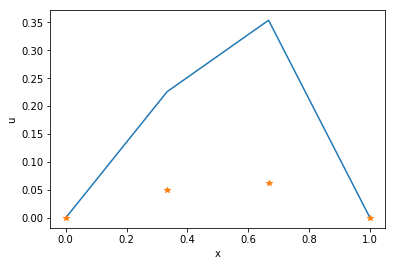

In [290]:
# reconstruct u
N_test = 10
x_test = np.linspace(xspan[0], xspan[1], N_test)
u = np.zeros(np.shape(x_test))

print(len(c))
for j in range(1,N+1):
    u += c[j-1] * hat_fun(x_test, x_nodes, j)

plt.figure()
plt.plot(x_test, u)
plt.plot(x_nodes, uhat(x_nodes), "*")
plt.xlabel('x')
plt.ylabel('u')
plt.show()